<a href="https://colab.research.google.com/github/nikolai-sannikov/dl_final_project/blob/main/dl_experiment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment setup

In [ ]:
import os
import time
from pathlib import Path

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import *
from tensorflow.keras.layers import *

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
print(f"Tensorflow version: {tf.__version__}")
print(f"Tensorflow datasets version: {tfds.__version__}")
tf.config.list_physical_devices()

Tensorflow version: 2.3.0
Tensorflow datasets version: 4.0.1


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Face crop

# LWF Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def display_images(images, titles= None):
  for i, image in enumerate(images):
    plt.subplot(1, len(images), i+1)
    if titles:
      plt.title(titles[i])
    disp_img = tf.image.grayscale_to_rgb(images[i])
    plt.imshow(disp_img)

  plt.show()

In [ ]:
lfw_filenames = tf.data.Dataset.list_files("drive/MyDrive/lfw_named/*.jpeg")
lfw = lfw_filenames.map(lambda filename: tf.io.decode_jpeg(tf.io.read_file(filename)),num_parallel_calls=tf.data.experimental.AUTOTUNE)
lfw = lfw.map(lambda img: tf.image.convert_image_dtype(img, tf.float32),num_parallel_calls=tf.data.experimental.AUTOTUNE)
lfw = lfw.take(4096).cache()
lfw = lfw.prefetch(tf.data.experimental.AUTOTUNE)
lfw_iter = iter(lfw)

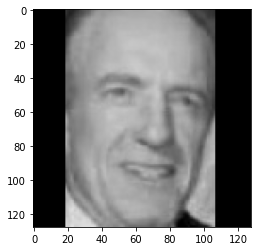

In [ ]:
sample_lfw = next(lfw_iter)
_ = plt.imshow(tf.image.grayscale_to_rgb(sample_lfw))

# Mugshot Dataset

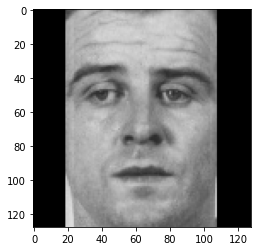

In [ ]:
mugshot_filenames = tf.data.Dataset.list_files("drive/MyDrive/mugshots_front/*.jpeg")
mugshots = mugshot_filenames.map(lambda filename: tf.io.decode_jpeg(tf.io.read_file(filename)),num_parallel_calls=tf.data.experimental.AUTOTUNE)
mugshots = mugshots.map(lambda img: tf.image.convert_image_dtype(img, tf.float32),num_parallel_calls=tf.data.experimental.AUTOTUNE)
mugshots = mugshots.cache()
mugshots = mugshots.prefetch(tf.data.experimental.AUTOTUNE)
sample_mugshot = next(iter(mugshots))
_ = plt.imshow(tf.image.grayscale_to_rgb(sample_mugshot))

# Training Encoder

Use encoder with reconstructing decoder to make sure embedding produced by encoder is suffient to capture the necessary image data

In [ ]:
def encoder_part(input):
    initializer = tf.random_normal_initializer(0., 0.02)
    x = Conv2D(16, kernel_size=(7, 7), strides=(2, 2), padding='same',  kernel_initializer=initializer,
                                use_bias=False, activation='relu', name='front_convolution')(
        input)
    x = BatchNormalization()(x)
    
    x = Conv2D(32, kernel_size=(5, 5), strides=(2, 2), padding='same', kernel_initializer=initializer,
                                use_bias=False, name='conv_enc_1')(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same',kernel_initializer=initializer,
                                use_bias=False, name='conv_enc_2')(x)
    x=tf.keras.layers.LeakyReLU()(x)   
    x = BatchNormalization()(x)

    x = Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same',kernel_initializer=initializer,
                                use_bias=False, name='conv_enc_3')(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x = BatchNormalization()(x)

    x = Conv2D(256, kernel_size=(5, 5), strides=(2, 2), padding='same',kernel_initializer=initializer,
                                use_bias=False, name='conv_enc_4')(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x = BatchNormalization()(x)

    x = Conv2D(512, kernel_size=(5, 5), strides=(2, 2), padding='same',kernel_initializer=initializer,
                                use_bias=False, name='conv_enc_5')(x)
    x=tf.keras.layers.LeakyReLU()(x)
    x = BatchNormalization()(x)
    return x

def decoder_part(encoded):
    initializer = tf.random_normal_initializer(0., 0.02)
    #dec = tf.reshape(dec, [-1, 8, 8, num_channels])
    x = encoded
    x = Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same',kernel_initializer=initializer,
                                use_bias=False, activation='relu', name='conv_dec_0')(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same',kernel_initializer=initializer,
                                use_bias=False, activation='relu', name='conv_dec_1')(x)
    x = BatchNormalization()(x)
    
    x = Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same',kernel_initializer=initializer,
                                use_bias=False, activation='relu', name='conv_dec_2')(x)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(32, kernel_size=(5, 5), strides=(2, 2), padding='same',kernel_initializer=initializer,
                                use_bias=False, activation='relu', name='conv_dec_3')(x)
    x = BatchNormalization()(x)
    
    x = Conv2DTranspose(16, kernel_size=(5, 5), strides=(2, 2), padding='same',kernel_initializer=initializer,
                                use_bias=False, activation='relu', name='conv_dec_4')(x)
    x = BatchNormalization()(x)

    decoded = Conv2DTranspose(1, kernel_size=(3, 3), strides=(2, 2), padding='same',kernel_initializer=initializer,
                                use_bias=False, activation='tanh', name='conv_out')(x)
    return decoded

def create_encoder():
    input = Input(shape=(128, 128, 1))
    encoded = encoder_part(input)
    print('Embedding size:',encoded.shape )
    return tf.keras.Model(inputs=input, outputs=encoded, name='encoder'), encoded.shape

def create_decoder(embedding_shape):
    encoded = Input(shape=embedding_shape)
    
    decoded = decoder_part(encoded)
    return tf.keras.Model(inputs=encoded, outputs=decoded, name='decoder')

In [ ]:
encoder_model, embedding_shape = create_encoder()
decoder_model_lfw = create_decoder(embedding_shape[1:])


encoder_decoder_lfw = tf.keras.Model(encoder_model.input, decoder_model_lfw(encoder_model.output), name='straight_decoder')

encoder_decoder_lfw.summary()

Embedding size: (None, 2, 2, 512)
Model: "straight_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
front_convolution (Conv2D)   (None, 64, 64, 16)        784       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 16)        64        
_________________________________________________________________
conv_enc_1 (Conv2D)          (None, 32, 32, 32)        12800     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv_enc_2 (Conv

In [ ]:
def image_diff_loss(generated, expected):
  return tf.reduce_sum(tf.abs(expected - generated))

decoder_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)

@tf.function
def train_step(model, input_image, expected_image):
  with tf.GradientTape() as dec_tape:
    decoded = model(input_image, training=True)    

    decoding_loss = image_diff_loss(decoded, expected_image)

  decoder_gradients = dec_tape.gradient(decoding_loss,
                                        model.trainable_variables)
  
  decoder_optimizer.apply_gradients(zip(decoder_gradients,
                                          model.trainable_variables))
  return decoding_loss

Epoch:  0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


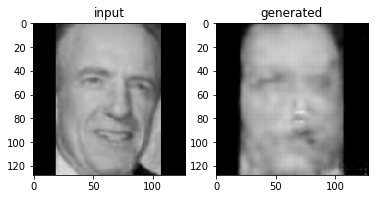

Time taken for epoch 1 is 3.9506781101226807 sec

Epoch:  1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


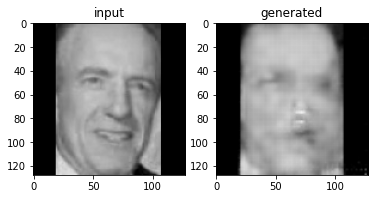

Time taken for epoch 2 is 3.146528482437134 sec

Epoch:  2

Epoch:  3

Epoch:  4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


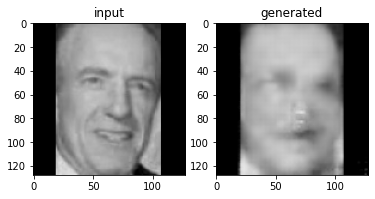

Time taken for epoch 5 is 3.372506618499756 sec

Epoch:  5

Epoch:  6

Epoch:  7

Epoch:  8

Epoch:  9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


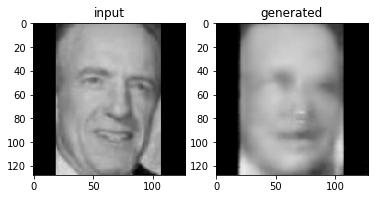

Time taken for epoch 10 is 3.43648362159729 sec

Epoch:  10

Epoch:  11

Epoch:  12

Epoch:  13

Epoch:  14

Epoch:  15

Epoch:  16

Epoch:  17

Epoch:  18

Epoch:  19

Epoch:  20

Epoch:  21

Epoch:  22

Epoch:  23

Epoch:  24

Epoch:  25

Epoch:  26

Epoch:  27

Epoch:  28

Epoch:  29

Epoch:  30

Epoch:  31

Epoch:  32

Epoch:  33

Epoch:  34

Epoch:  35

Epoch:  36

Epoch:  37

Epoch:  38

Epoch:  39

Epoch:  40

Epoch:  41

Epoch:  42

Epoch:  43

Epoch:  44

Epoch:  45

Epoch:  46

Epoch:  47

Epoch:  48

Epoch:  49

Epoch:  50

Epoch:  51

Epoch:  52

Epoch:  53

Epoch:  54

Epoch:  55

Epoch:  56

Epoch:  57

Epoch:  58

Epoch:  59

Epoch:  60

Epoch:  61

Epoch:  62

Epoch:  63

Epoch:  64

Epoch:  65

Epoch:  66

Epoch:  67

Epoch:  68

Epoch:  69

Epoch:  70

Epoch:  71

Epoch:  72

Epoch:  73

Epoch:  74

Epoch:  75

Epoch:  76

Epoch:  77

Epoch:  78

Epoch:  79

Epoch:  80

Epoch:  81

Epoch:  82

Epoch:  83

Epoch:  84

Epoch:  85

Epoch:  86

Epoch:  87

Epoch:  88

Epo

KeyboardInterrupt: ignored

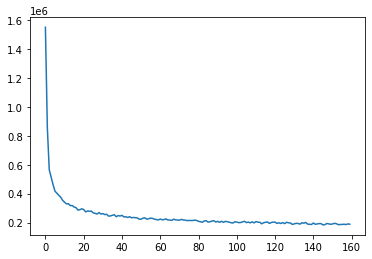

In [ ]:
epochs_passed = 0
next_stop_epoch = 500
losses = []
read_times = []

while epochs_passed <= next_stop_epoch:
    start = time.time()
    print("Epoch: ", epochs_passed)
    
    # Train
    prev_read = time.time()
    for input in lfw.batch(256):
      read_time = time.time()-prev_read
      read_times.append(read_time)
      with tf.device('device:GPU:0'):
        train_start = time.time()
        loss = train_step(encoder_decoder_lfw, input, input)        
        losses.append(loss)
      prev_read = time.time()
    print()

    if (next_stop_epoch/(epochs_passed+1)%(next_stop_epoch/10)==0):
      gen_output = encoder_decoder_lfw(sample_lfw[tf.newaxis, ...], training=False)
      gen_output = gen_output[0]
      display_images((sample_lfw, gen_output), ('input', 'generated'))
      print ('Time taken for epoch {} is {} sec\n'.format(epochs_passed + 1,
                                                        time.time()-start))
      plt.plot(losses)
    epochs_passed+=1

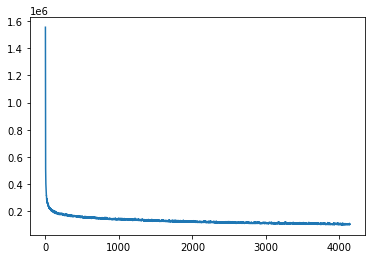

In [ ]:
plt.plot(losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


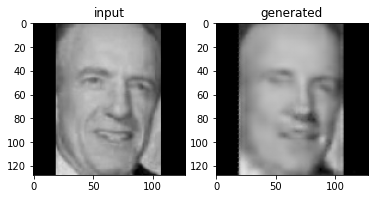

In [ ]:
gen_output = encoder_decoder_lfw(sample_lfw[tf.newaxis, ...], training=False)
gen_output = gen_output[0]
display_images((sample_lfw, gen_output), ('input', 'generated'))

In [ ]:
decoder_model_mugshot = create_decoder(embedding_shape[1:])
encoder_decoder_mugshot = tf.keras.Model(encoder_model.input, decoder_model_mugshot(encoder_model.output), name='mugshot_decoder')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


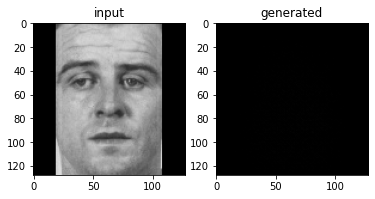

Time taken for epoch 1 is 2.6082136631011963 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


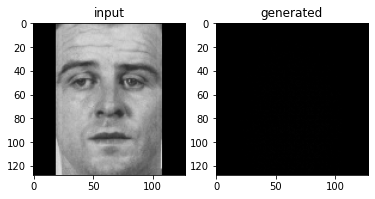

Time taken for epoch 2 is 1.4336133003234863 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


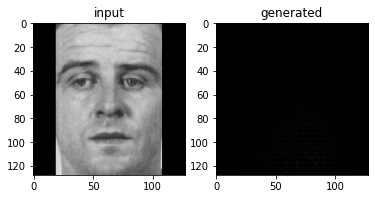

Time taken for epoch 5 is 1.5830607414245605 sec



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


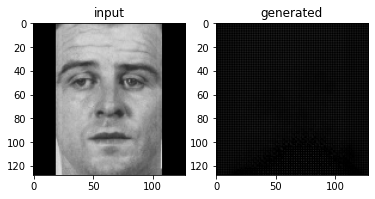

Time taken for epoch 10 is 1.60109543800354 sec



In [ ]:
epochs_passed = 0
next_stop_epoch = 500
mugshot_losses = []
read_times = []

while epochs_passed <= next_stop_epoch:
    start = time.time()
    #print("Epoch: ", epochs_passed)
    
    # Train
    prev_read = time.time()
    for input in mugshots.batch(256):
      read_time = time.time()-prev_read
      read_times.append(read_time)
      with tf.device('device:GPU:0'):
        train_start = time.time()
        loss = train_step(encoder_decoder_mugshot, input, input)        
        mugshot_losses.append(loss)
      prev_read = time.time()
    #print()

    if ((next_stop_epoch/(epochs_passed+1))%(next_stop_epoch/10)==0):
      gen_output = encoder_decoder_mugshot(sample_mugshot[tf.newaxis, ...], training=False)
      gen_output = gen_output[0]
      display_images((sample_mugshot, gen_output), ('input', 'generated'))
      print ('Time taken for epoch {} is {} sec\n'.format(epochs_passed + 1,
                                                        time.time()-start))
      #plt.plot(losses)
    epochs_passed+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


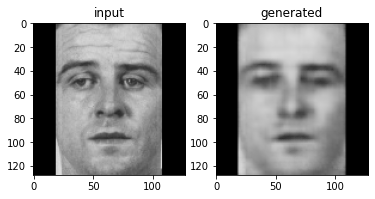

In [ ]:
gen_output = encoder_decoder_mugshot(sample_mugshot[tf.newaxis, ...], training=False)
gen_output = gen_output[0]
display_images((sample_mugshot, gen_output), ('input', 'generated'))

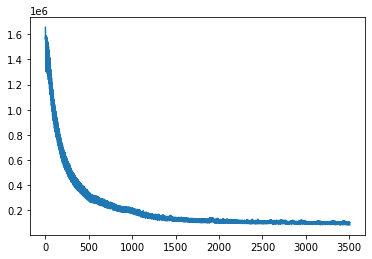

In [ ]:
plt.plot(mugshot_losses)

Try to use decoders on domains they were not initially trained for:
* lfw image -> mugshot decoder -> mugshot-like image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


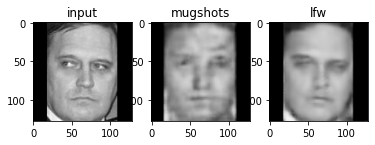

In [ ]:
another_sample_lfw = next(lfw_iter)
mg_output = encoder_decoder_mugshot(another_sample_lfw[tf.newaxis, ...], training=False)
mg_output = mg_output[0]

lfw_output = encoder_decoder_lfw(another_sample_lfw[tf.newaxis, ...], training=False)
lfw_output = lfw_output[0]


display_images((another_sample_lfw, mg_output, lfw_output), ('input', 'mugshots', 'lfw'))

# Transformation learning Decoder

# Discriminator

In [ ]:
def create_discriminator():
    initializer = tf.random_normal_initializer(0., 1)
    input = Input(shape=(128,128,1))

    x = Conv2D(32, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer,
                                use_bias=False)(input)
    x=tf.keras.layers.LeakyReLU()(x)
    #x = LayerNormalization()(x)
    
    x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer,
                                use_bias=False)(x)
    x=tf.keras.layers.LeakyReLU()(x)
    #x = LayerNormalization()(x)

    x = Conv2D(128, kernel_size=(4, 4), strides=(1, 1), padding='same', kernel_initializer=initializer,
                                use_bias=False)(x)
    x=tf.keras.layers.LeakyReLU()(x)

    x = Conv2D(64, kernel_size=(4, 4), strides=(1, 1), padding='same', kernel_initializer=initializer,
                                use_bias=False)(x)
    x=tf.keras.layers.LeakyReLU()(x)

    x = Conv2D(32, kernel_size=(4, 4), strides=(1, 1), padding='same', kernel_initializer=initializer,
                                use_bias=False)(x)
    x=tf.keras.layers.LeakyReLU()(x)

    
    x = Conv2D(16, kernel_size=(4, 4), strides=(1, 1), padding='same', kernel_initializer=initializer,
                                use_bias=False)(x)
    x=tf.keras.layers.LeakyReLU()(x)

    x = Conv2D(8, kernel_size=(4, 4), strides=(1, 1), padding='same', kernel_initializer=initializer,
                                use_bias=False)(x)
    x=tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.BatchNormalization()(x)
    x = Conv2D(1, kernel_size=(4, 4), strides=(1, 1), padding='same', kernel_initializer=initializer,
                                use_bias=False)(x)
    x=tf.keras.layers.LeakyReLU()(x)
    '''

    x = Conv2D(32, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer,
                                use_bias=False)(x)
    x=tf.keras.layers.LeakyReLU()(x)
    #x = LayerNormalization()(x)

    x = Conv2D(64, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer,
                                use_bias=False)(x)
    x=tf.keras.layers.LeakyReLU()(x)
    #x = LayerNormalization()(x)

    x = Conv2D(128, kernel_size=(4, 4), strides=(2, 2), padding='same', kernel_initializer=initializer,
                                use_bias=False)(x)
    x=tf.keras.layers.LeakyReLU()(x)


    #x = LayerNormalization()(x)

    #x = Flatten()(x)
    
    #x = Dense(256, activation='sigmoid')(x)

    #x = Dense(1, activation='sigmoid')(x)
    '''
    return Model(inputs=input, outputs=x, name='discriminator')

discriminator = create_discriminator()
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_219 (Conv2D)          (None, 64, 64, 32)        512       
_________________________________________________________________
leaky_re_lu_224 (LeakyReLU)  (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_220 (Conv2D)          (None, 32, 32, 64)        32768     
_________________________________________________________________
leaky_re_lu_225 (LeakyReLU)  (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_221 (Conv2D)          (None, 32, 32, 128)       131072    
_________________________________________________________________
leaky_re_lu_226 (LeakyReLU)  (None, 32, 32, 128)     

First, try to train discriminator without touching decoder to make sure it starts with some signals useful to train decoder in the future

In [ ]:
def discriminator_loss(disc_real_output, disc_fake_output):
  real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
  generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_fake_output), disc_fake_output)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss


discriminator_optimizer = tf.keras.optimizers.Adam(2e-2, beta_1=0.5, beta_2=0.999)
decoder_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)

def generator_loss(disc_fake_output):
  gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_fake_output), disc_fake_output)
  return gan_loss

@tf.function
def train_step_align(encoder, decoder, discriminator, lfw_image, mugshot_image):
  with tf.GradientTape() as disc_tape:
    encoded = encoder(lfw_image, training=False)    
    generated = decoder(encoded, training=False)
    score_real = discriminator(mugshot_image, training = True)
    score_fake = discriminator(generated, training = True)
    
    disc_loss = discriminator_loss(score_real, score_fake)
    gen_loss = generator_loss(score_fake)

  dicriminator_gradients = disc_tape.gradient(disc_loss,
                                              discriminator.trainable_variables)
  #decoder_gradients = dec_tape.gradient(gen_loss,
  #                                    decoder.trainable_variables)
  
  discriminator_optimizer.apply_gradients(zip(dicriminator_gradients,
                                          discriminator.trainable_variables))

  #decoder_optimizer.apply_gradients(zip(decoder_gradients,
  #                                        decoder.trainable_variables))

  return gen_loss, disc_loss

In [ ]:
decoder_mugshot_2 = decoder_model_mugshot
aligner = tf.keras.Model(encoder_model.input, decoder_mugshot_2(encoder_model.output), name='mugshot_decoder')

In [ ]:
epochs_passed = 0
next_stop_epoch = 100
disc_losses = []
gen_losses = []

while epochs_passed <= next_stop_epoch:
    start = time.time()
    print("Epoch: ", epochs_passed)
    
    # Train    
    for lfw_image,mugshot_image in  tf.data.Dataset.zip((lfw, mugshots)).batch(256):      
      #print('.', end='')      
      train_start = time.time()
      with tf.device('device:GPU:0'):        
        gen_loss, disc_loss = train_step_align(encoder_model, decoder_model_mugshot, discriminator, lfw_image, mugshot_image)        
      print(gen_loss, disc_loss)
      disc_losses.append(disc_loss)
      gen_losses.append(gen_loss)
      last_lfw = lfw_image[0]
      last_mugshot = mugshot_image[0]
      #print ('Time taken to train: {}'.format(time.time()-train_start))      
    print()

    clear_output(wait=True)
    #display_images((last_lfw, last_mugshot))
    gen_output = aligner(sample_lfw[tf.newaxis, ...], training=False)
    gen_output = gen_output[0]
    score = discriminator(gen_output[tf.newaxis, ...], training=False)
    display_images((sample_lfw, gen_output), ('input', str(tf.math.reduce_sum(score))))
    print ('Time taken for epoch {} is {} sec\n'.format(epochs_passed + 1,
                                                        time.time()-start))
    epochs_passed+=1

Epoch:  0


ValueError: ignored

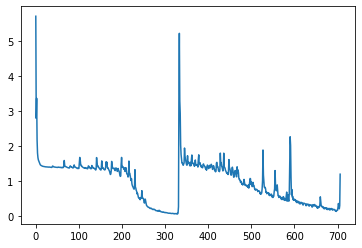

In [ ]:
plt.plot(disc_losses)

Now train both pre-trained discriminator and decoder prepared for restricted (mugshot) photos

In [ ]:
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)
decoder_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5, beta_2=0.999)

@tf.function
def train_step_align(encoder, decoder, discriminator, lfw_image, mugshot_image):
  with tf.GradientTape() as dec_tape, tf.GradientTape() as disc_tape:
    encoded = encoder(lfw_image, training=True)    
    generated = decoder(encoded, training=True)
    score_real = discriminator(mugshot_image, training = False)
    score_fake = discriminator(generated, training = False)
    
    disc_loss = discriminator_loss(score_real, score_fake)
    gen_loss = generator_loss(score_fake)


  dicriminator_gradients = disc_tape.gradient(disc_loss,
                                              discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(dicriminator_gradients,
                                          discriminator.trainable_variables))

  decoder_gradients = dec_tape.gradient(gen_loss,
                                        decoder.trainable_variables)
  decoder_optimizer.apply_gradients(zip(decoder_gradients,
                                          decoder.trainable_variables))
  return gen_loss, disc_loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


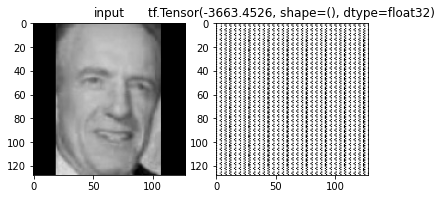

Time taken for epoch 2 is 4.3372461795806885 sec

Epoch:  2
tf.Tensor(3.6793532, shape=(), dtype=float32) tf.Tensor(0.19472505, shape=(), dtype=float32)
Time taken to train: 0.5814371109008789
tf.Tensor(3.6979878, shape=(), dtype=float32) tf.Tensor(0.19120157, shape=(), dtype=float32)
Time taken to train: 0.5999839305877686
tf.Tensor(3.718252, shape=(), dtype=float32) tf.Tensor(0.18817997, shape=(), dtype=float32)
Time taken to train: 0.5861401557922363


KeyboardInterrupt: ignored

In [ ]:
epochs_passed = 0
next_stop_epoch = 1000
disc_losses_2 = []
gen_losses = []

while epochs_passed <= next_stop_epoch:
    start = time.time()
    print("Epoch: ", epochs_passed)
    
    # Train
    prev_read = time.time()
    for lfw_image,mugshot_image in  tf.data.Dataset.zip((lfw, mugshots)).batch(256):
      #print ('Time taken to read data: {}'.format(time.time()-prev_read))
      #print('.', end='')      
      with tf.device('device:GPU:0'):
        train_start = time.time()
        gen_loss, disc_loss = train_step_align(encoder_model, decoder_mugshot_2, discriminator, lfw_image, mugshot_image)        
        print(gen_loss, disc_loss)
        disc_losses.append(disc_loss)
        gen_losses.append(gen_loss)
        print ('Time taken to train: {}'.format(time.time()-train_start))
      prev_read = time.time()
    print()

    clear_output(wait=True)
    
    gen_output = aligner(sample_lfw[tf.newaxis, ...], training=False)
    gen_output = gen_output[0]
    score = discriminator(gen_output[tf.newaxis, ...], training=False)
    display_images((sample_lfw, gen_output), ('input', str(tf.math.reduce_sum(score))))
    print ('Time taken for epoch {} is {} sec\n'.format(epochs_passed + 1,
                                                        time.time()-start))
    epochs_passed+=1

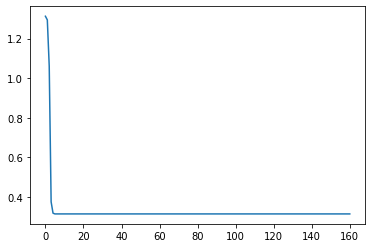

In [ ]:
plt.plot(gen_losses)

Use both fresh discriminator and decoder as the last attempt to get something useful given many iterations

In [ ]:
#encoder_model_fresh = create_encoder(embedding_shape[1:])
decoder_model_fresh = create_decoder(embedding_shape[1:])
discriminator_fresh = create_discriminator()
aligner_2 = tf.keras.Model(encoder_model.input, decoder_model_fresh(encoder_model.output), name='mugshot_decoder')

In [ ]:
discriminator_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5, beta_2=0.999)
decoder_optimizer = tf.keras.optimizers.Adam(2e-3, beta_1=0.5, beta_2=0.999)

@tf.function
def train_step_align_2(encoder, decoder, discriminator, lfw_image, mugshot_image):
  with tf.GradientTape() as dec_tape, tf.GradientTape() as disc_tape:
    encoded = encoder(lfw_image, training=True)    
    generated = decoder(encoded, training=True)
    score_real = discriminator(mugshot_image, training = True)
    score_fake = discriminator(generated, training = True)
    
    disc_loss = discriminator_loss(score_real, score_fake)
    gen_loss = generator_loss(score_fake)


  dicriminator_gradients = disc_tape.gradient(disc_loss,
                                              discriminator.trainable_variables)
  decoder_gradients = dec_tape.gradient(gen_loss,
                                        decoder.trainable_variables)
  
  discriminator_optimizer.apply_gradients(zip(dicriminator_gradients,
                                          discriminator.trainable_variables))

  decoder_optimizer.apply_gradients(zip(decoder_gradients,
                                          decoder.trainable_variables))
  return gen_loss, disc_loss

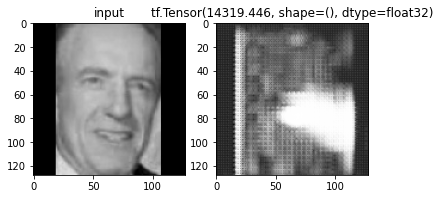

Time taken for epoch 159 is 4.460761785507202 sec

Epoch:  159
tf.Tensor(0.702688, shape=(), dtype=float32) tf.Tensor(1.2429957, shape=(), dtype=float32)
Time taken to train: 0.5960583686828613
tf.Tensor(0.7034101, shape=(), dtype=float32) tf.Tensor(1.2367681, shape=(), dtype=float32)
Time taken to train: 0.6158678531646729
tf.Tensor(0.70615953, shape=(), dtype=float32) tf.Tensor(1.2274075, shape=(), dtype=float32)
Time taken to train: 0.6027719974517822
tf.Tensor(0.7057341, shape=(), dtype=float32) tf.Tensor(1.2205956, shape=(), dtype=float32)
Time taken to train: 0.6084511280059814
tf.Tensor(0.70624435, shape=(), dtype=float32) tf.Tensor(1.2113996, shape=(), dtype=float32)
Time taken to train: 0.601426362991333
tf.Tensor(0.71152085, shape=(), dtype=float32) tf.Tensor(1.2046022, shape=(), dtype=float32)
Time taken to train: 0.606677770614624


KeyboardInterrupt: ignored

In [ ]:
epochs_passed = 0
next_stop_epoch = 1000
disc_losses_2 = []
gen_losses_2 = []

while epochs_passed <= next_stop_epoch:
    start = time.time()
    print("Epoch: ", epochs_passed)
    
    # Train
    prev_read = time.time()
    for lfw_image,mugshot_image in  tf.data.Dataset.zip((lfw, mugshots)).batch(256):
      #print ('Time taken to read data: {}'.format(time.time()-prev_read))
      #print('.', end='')      
      with tf.device('device:GPU:0'):
        train_start = time.time()
        gen_loss, disc_loss = train_step_align_2(encoder_model, decoder_model_fresh, discriminator_fresh, lfw_image, mugshot_image)        
        print(gen_loss, disc_loss)
        disc_losses.append(disc_loss)
        gen_losses.append(gen_loss)
        print ('Time taken to train: {}'.format(time.time()-train_start))
      prev_read = time.time()
    print()

    clear_output(wait=True)
    
    gen_output = aligner_2(sample_lfw[tf.newaxis, ...], training=False)
    gen_output = gen_output[0]
    score = discriminator(gen_output[tf.newaxis, ...], training=False)
    display_images((sample_lfw, gen_output), ('input', str(tf.math.reduce_sum(score))))
    print ('Time taken for epoch {} is {} sec\n'.format(epochs_passed + 1,
                                                        time.time()-start))
    epochs_passed+=1